# Load Data



## Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [4]:
from dotenv import load_dotenv

load_dotenv()


True

## Load Packages

In [5]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

from src import fetch
from src import config
from src import preprocessing


In [ ]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date
from importlib import reload

## Load Data

In [4]:
data_path = Path("../data/landing/311-service-requests")

lf = pl.scan_parquet(
    str(data_path / "**/*.parquet"),
    hive_partitioning=True,
)

## Subset Data to DOHMH

In [5]:
# Filter for DOHMH agency and add derived columns
dohmh_data_only = lf.filter(pl.col("agency") == "DOHMH").select([
    "due_date",
    "landmark",
    "intersection_street_1",
    "intersection_street_2",
    "facility_type",
    "cross_street_2",
    "cross_street_1",
    "bbl",
    "location_type",
    "street_name",
    "incident_address",
    "address_type",
    "longitude",
    "latitude",
    "x_coordinate_state_plane",
    "y_coordinate_state_plane",
    "city",
    "incident_zip",
    "resolution_description",
    "closed_date",
    "resolution_action_updated_date",
    "descriptor",
    "community_board",
    "park_borough",
    "borough",
    "unique_key",
    "created_date",
    "agency_name",
    "agency",
    "complaint_type",
    "status",
    "open_data_channel_type",
    "park_facility_name",
    "year",
    "month"
]).collect()

df_orig = dohmh_data_only.to_pandas()

## Data Cleanup

### Fill Rates

In [6]:
# Plot missing values by column (similar to the reference image)
missing_counts = df_orig.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show columns with missing values

# Calculate percentages for display
missing_percentages = (missing_counts / len(df_orig) * 100).round(1)

fig = go.Figure()

# Create bar chart
fig.add_trace(go.Bar(
    x=list(range(len(missing_counts))),
    y=missing_counts.values,
    text=[f'{pct}%' for pct in missing_percentages.values],
    textposition='outside',
    textangle=0,
    showlegend=False
))

# Update layout to match the reference style
fig.update_layout(
    title='Missing Values by Column',
    xaxis_title='Column',
    yaxis_title='Number of Missing Values',
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(missing_counts))),
        ticktext=missing_counts.index,
        tickangle=-45
    ),
    height=600,
    margin=dict(b=120)  # Extra bottom margin for rotated labels
)

fig.show()


In [7]:
# Calculate overall fill rates
df_fill_rates = pd.DataFrame({
    'overall': df_orig.notna().sum() / len(df_orig)
}).round(3)

# Fill rates by borough
df_fill_rates_borough = df_orig.groupby('borough').apply(lambda x: x.notna().sum() / len(x)).round(3)
df_fill_rates_borough.insert(0, 'total_count', df_orig.groupby('borough').size())

# Fill rates by complaint_type
df_fill_rates_complaint = df_orig.groupby('complaint_type').apply(lambda x: x.notna().sum() / len(x)).round(3)
df_fill_rates_complaint.insert(0, 'total_count', df_orig.groupby('complaint_type').size())

# Plot 1: Borough fill rates vs overall
fig1 = go.Figure()
for borough in df_fill_rates_borough.index:
    borough_data = df_fill_rates_borough.loc[borough]
    overall_data = df_fill_rates['overall']
    
    # Get matching columns (excluding total_count)
    common_cols = [col for col in borough_data.index if col in overall_data.index and col != 'total_count']
    
    fig1.add_trace(go.Scatter(
        x=overall_data[common_cols],
        y=borough_data[common_cols],
        mode='markers',
        name=borough,
        text=common_cols,
        hovertemplate='%{text}<br>Overall: %{x}<br>' + f'{borough}: %{{y}}<extra></extra>'
    ))

fig1.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfect Match',
    line=dict(dash='dash', color='gray')
))

fig1.update_layout(
    title='Borough Fill Rates vs Overall Fill Rates',
    xaxis_title='Overall Fill Rate',
    yaxis_title='Borough Fill Rate',
    showlegend=True
)
fig1.show()

# Plot 2: Complaint type fill rates vs overall (top 20 by count)
top_complaints = df_fill_rates_complaint.nlargest(20, 'total_count')

fig2 = go.Figure()
for complaint in top_complaints.index:
    complaint_data = top_complaints.loc[complaint]
    overall_data = df_fill_rates['overall']
    
    # Get matching columns (excluding total_count)
    common_cols = [col for col in complaint_data.index if col in overall_data.index and col != 'total_count']
    
    fig2.add_trace(go.Scatter(
        x=overall_data[common_cols],
        y=complaint_data[common_cols],
        mode='markers',
        name=complaint,
        text=common_cols,
        hovertemplate='%{text}<br>Overall: %{x}<br>' + f'{complaint}: %{{y}}<extra></extra>'
    ))

fig2.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfect Match',
    line=dict(dash='dash', color='gray')
))

fig2.update_layout(
    title='Top 20 Complaint Types Fill Rates vs Overall Fill Rates',
    xaxis_title='Overall Fill Rate',
    yaxis_title='Complaint Type Fill Rate',
    showlegend=True
)
fig2.show()


C:\Users\gorav\AppData\Local\Temp\ipykernel_30376\1177816533.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\gorav\AppData\Local\Temp\ipykernel_30376\1177816533.py:11: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Duplicates

In [8]:
print('Row Count:', len(df_orig))

df_orig = df_orig.drop_duplicates(keep = 'first')
print('Row Count:', len(df_orig))

df_orig['created_date_hour'] = df_orig['created_date'].dt.floor('H')


Row Count: 1030037
Row Count: 952212


C:\Users\gorav\AppData\Local\Temp\ipykernel_30376\3799280734.py:6: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [9]:
df_temp = df_orig[df_orig.duplicated(subset=["created_date", "complaint_type", "incident_address", "borough"], keep = False)]
for i in df_temp['incident_address'].unique()[:5]:
    df_address = df_temp[df_temp['incident_address'] == i]
    print(i)
    for j in range(len(df_address['resolution_description'])):
        print(df_address['created_date'].iloc[j])
        print(df_address['complaint_type'].iloc[j])
        print(df_address['descriptor'].iloc[j])
        print(df_address['resolution_description'].iloc[j])
        print('--------------------------------')
    print('------------------------------------------------------------------')
    print()

None
------------------------------------------------------------------

118-10 150 AVENUE
2010-07-01 00:00:00
Rodent
Condition Attracting Rodents
Please contact the Department of Health and Mental Hygiene's Pest Control Services for updated status of your complaint by calling (718) 520-4974.
--------------------------------
2010-07-01 00:00:00
Rodent
Condition Attracting Rodents
Please contact the Department of Health and Mental Hygiene's Pest Control Services for updated status of your complaint by calling (718) 520-4974.
--------------------------------
------------------------------------------------------------------

382 WADSWORTH AVENUE
2010-07-01 00:00:00
Rodent
Rat Sighting
Please contact the Department of Health and Mental Hygiene's Pest Control Services for updated status of your complaint by calling (212) 360-5928.
--------------------------------
2010-07-01 00:00:00
Rodent
Condition Attracting Rodents
Please contact the Department of Health and Mental Hygiene's Pest Contro

In [10]:
df_temp = df_orig[df_orig.duplicated(subset=["created_date_hour", "complaint_type", "incident_address", "borough"], keep = False)]
for i in df_temp['incident_address'].unique()[:5]:
    df_address = df_temp[df_temp['incident_address'] == i]
    print(i)
    for j in range(len(df_address['resolution_description'])):
        print(df_address['created_date'].iloc[j])
        print(df_address['complaint_type'].iloc[j])
        print(df_address['descriptor'].iloc[j])
        print(df_address['resolution_description'].iloc[j])
        print('--------------------------------')
    print('--------------------------------' * 2)
    print()

1159 CARROLL STREET
2010-01-03 11:14:34
Smoking
Smoking Violation
The Department of Health and Mental Hygiene cannot send official written documentation because the mailing information provided was incorrect or incomplete.  Please verify the mailing information provided and log another complaint.
--------------------------------
2010-01-03 11:57:11
Smoking
Smoking Violation
The Department of Health and Mental Hygiene has received and processed your complaint.  The facility will receive an inspection from the Bureau of Food Safety and Community Sanitation.  Inspection results are not published.
--------------------------------
----------------------------------------------------------------

1769 VYSE AVENUE
2010-01-03 13:09:50
Rodent
Mouse Sighting
Please contact the Department of Health and Mental Hygiene's Pest Control Services for updated status of your complaint by calling (718) 583-6133.
--------------------------------
2010-01-03 13:39:15
Rodent
Condition Attracting Rodents
Pleas

In [11]:
df_orig = df_orig.drop_duplicates(subset=["created_date_hour", "complaint_type", "incident_address", "borough", "descriptor", "resolution_description"])
print('Row Count:', len(df_orig))

Row Count: 928356


### Freetext Columns

In [12]:
def map_freetext_columns(df):
        dict_mappings = pd.read_excel(os.path.abspath(os.path.join(os.getcwd(), '..', 'src', 'resources', "mappings", "freetext_column_mappings.xlsx")), sheet_name = None)
        df_complaint_type = dict_mappings['complaint_type']
        df_descriptor = dict_mappings['descriptor']
        df_resolution_description = dict_mappings['resolution_description']

        df = df.merge(df_complaint_type, on = 'complaint_type', how = 'left')
        df = df.merge(df_descriptor, on = 'descriptor', how = 'left')
        df = df.merge(df_resolution_description, on = 'resolution_description', how = 'left')
        broken_string = 'this case was an isolated incident'

        df['resolution_outcome'] = np.where(df['resolution_description'].str.contains(broken_string), "inspection", df['resolution_outcome'])

        return df

In [13]:
df_orig = map_freetext_columns(df_orig)

In [14]:
top_complaint_families = pd.DataFrame()
top_complaint_families['count'] = df_orig['complaint_family'].value_counts()
top_complaint_families['pct'] = df_orig['complaint_family'].value_counts(normalize=True)


top_complaint_families



,count,pct
complaint_family,,
vector_control,483382,0.520686
food_safety,198853,0.214199
air_smoke_mold,132134,0.142331
animal_control,55146,0.059402
housing_health,18227,0.019634
childcare_recreation,14261,0.015362
hazmat_lead_asbestos,13131,0.014144
covid,8020,0.008639
water_quality,2890,0.003113


In [15]:
df_orig = df_orig[df_orig['complaint_family'].isin(top_complaint_families.index[:4])]
print('Row Count:', len(df_orig))

Row Count: 869515


In [16]:
df_orig = df_orig[df_orig['resolution_outcome'] != 'duplicate_of_previous']
print('Row Count:', len(df_orig))


Row Count: 792190


In [17]:
df_orig[df_orig['resolution_description'].isna()]['resolution_outcome'].value_counts()

resolution_outcome
unknown    37507
Name: count, dtype: int64

### Closing Date Checks

In [17]:
df_orig[['created_date', 'due_date', 'closed_date', 'resolution_action_updated_date']].head()

,created_date,due_date,closed_date,resolution_action_updated_date
0,2010-01-01 08:20:22,2010-02-07 08:20:22,NaT,2010-01-04 11:38:30
1,2010-01-01 08:29:58,2010-01-31 08:29:58,NaT,2010-01-01 08:37:34
3,2010-01-01 10:35:38,2010-01-15 10:35:38,NaT,2010-01-15 07:37:07
4,2010-01-01 10:43:52,2010-01-31 10:43:52,2010-01-14 10:51:48,2010-01-14 10:51:48
5,2010-01-01 11:20:45,2010-01-31 11:20:45,NaT,2010-01-01 11:30:23


In [18]:
df_orig[['created_date', 'due_date', 'closed_date', 'resolution_action_updated_date']].notna().sum() / len(df_orig)

created_date                      1.000000
due_date                          0.595158
closed_date                       0.862106
resolution_action_updated_date    0.957027
dtype: float64

In [19]:
df_orig['date'] = df_orig['created_date'].dt.date

df_orig['time_to_resolution'] = df_orig['closed_date'] - df_orig['created_date']
df_orig['time_closed_to_resolution_update'] = df_orig['resolution_action_updated_date'] - df_orig['closed_date']
df_orig['closed_before_created'] = df_orig['time_to_resolution'] < pd.Timedelta(0)
df_orig['identical_created_closed_dates'] = df_orig['time_to_resolution'] == pd.Timedelta(0)
df_orig['created_at_midnight'] = df_orig['created_date'].dt.time == pd.Timestamp('00:00:00').time()
df_orig['closed_at_midnight'] = df_orig['closed_date'].dt.time == pd.Timestamp('00:00:00').time()


In [20]:


# Calculate percentages for reporting
total_rows = len(df_orig)
pct_closed_before_created = (df_orig['closed_before_created'].sum() / total_rows) * 100
pct_identical_dates = (df_orig['identical_created_closed_dates'].sum() / total_rows) * 100
pct_created_midnight = (df_orig['created_at_midnight'].sum() / total_rows) * 100
pct_closed_midnight = (df_orig['closed_at_midnight'].sum() / total_rows) * 100

print("Data Quality Summary:")
print(f"Total rows: {total_rows:,}")
print(f"Percent closed before created date: {pct_closed_before_created:.2f}%")
print(f"Percent with identical created and closed dates: {pct_identical_dates:.2f}%")
print(f"Percent created at midnight: {pct_created_midnight:.2f}%")
print(f"Percent closed at midnight: {pct_closed_midnight:.2f}%")

Data Quality Summary:
Total rows: 792,190
Percent closed before created date: 0.57%
Percent with identical created and closed dates: 22.71%
Percent created at midnight: 33.31%
Percent closed at midnight: 26.53%


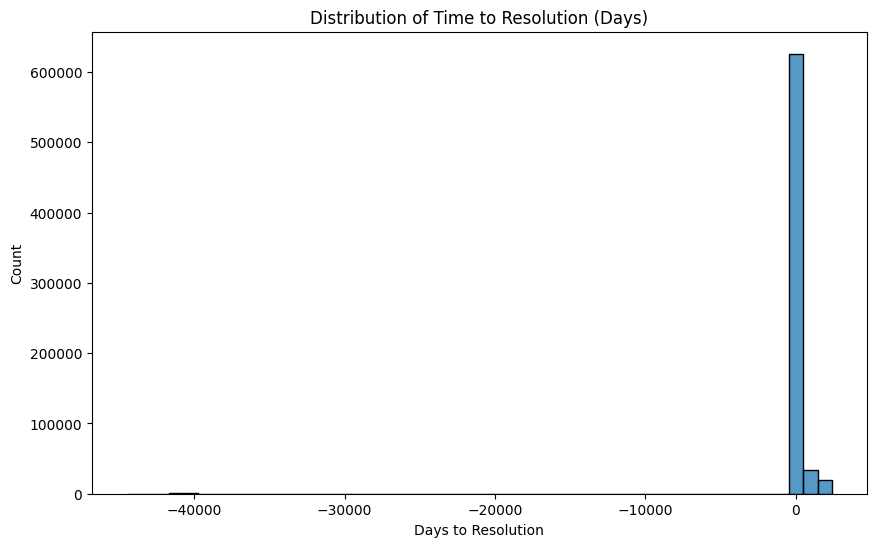

In [21]:
# Create histogram of time to resolution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_orig, x=df_orig['time_to_resolution'].dt.days, bins=50)
plt.title('Distribution of Time to Resolution (Days)')
plt.xlabel('Days to Resolution')
plt.ylabel('Count')
plt.show()

In [22]:
df_orig = df_orig[df_orig['closed_before_created'] == 0]
print('Row Count:', len(df_orig))


Row Count: 787670


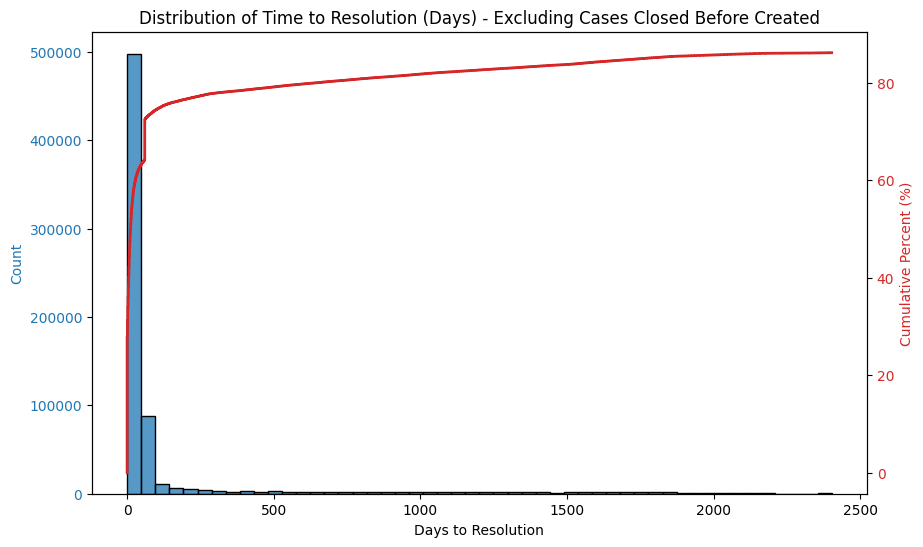

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create histogram on primary y-axis
sns.histplot(data=df_orig, x=df_orig['time_to_resolution'].dt.days, bins=50, ax=ax1)
ax1.set_xlabel('Days to Resolution')
ax1.set_ylabel('Count', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis for cumulative percentage
ax2 = ax1.twinx()
days_to_resolution = df_orig['time_to_resolution'].dt.days.sort_values()
cumulative_percent = [(i / len(days_to_resolution)) * 100 for i in range(1, len(days_to_resolution) + 1)]
ax2.plot(days_to_resolution, cumulative_percent, color='tab:red', linewidth=2, label='Cumulative Percent')
ax2.set_ylabel('Cumulative Percent (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Time to Resolution (Days) - Excluding Cases Closed Before Created')
plt.show()


In [24]:
df_orig = df_orig[df_orig['identical_created_closed_dates'] == 0]
print('Row Count:', len(df_orig))


Row Count: 607740


### Remaining issues
- what to do about tickets that involve midnight:
 - create a flag for duration modeling that says it likely invovles a automated system for closing
- tickets closed at 60 and 61 days, but not value at midnight
  - create flag that it likely involves an automated system for duration modeling
- tickets with really long closure dates
  - keep in, just right censor them for duration modeling a
- tickets made early in the morning

  - look into other columns
   - open_data_channel_type

Censoring:
1. greater than 365 are capped
2. wh

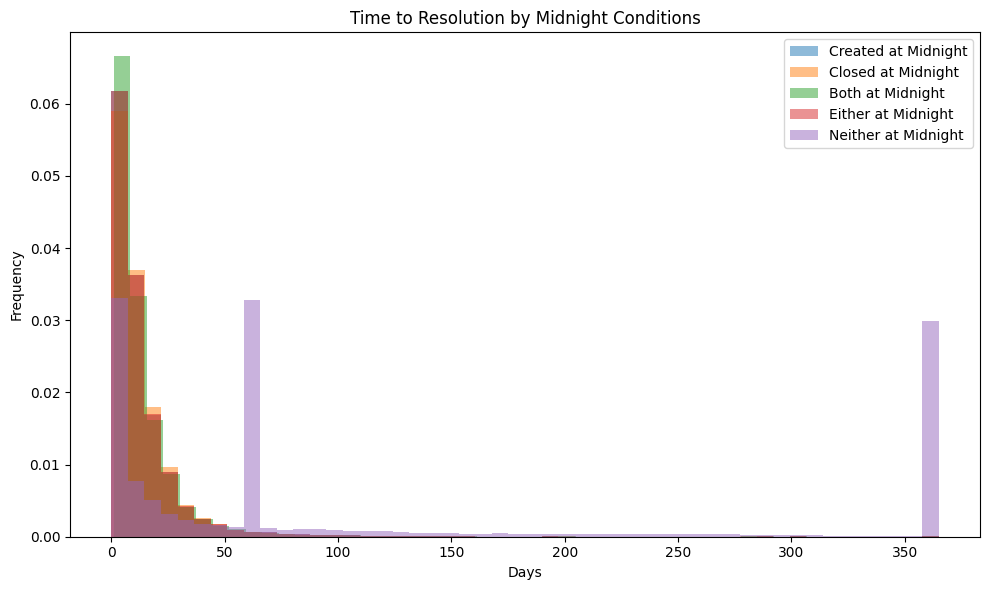

Created at Midnight - Count: 220298
Closed at Midnight - Count: 164478
Both at Midnight - Count: 163323
Either at Midnight - Count: 221453
Neither at Midnight - Count: 386287


In [25]:
# Create subsets based on midnight conditions
created_midnight = df_orig[df_orig['created_at_midnight'] == True]
closed_midnight = df_orig[df_orig['closed_at_midnight'] == True]
both_midnight = df_orig[(df_orig['created_at_midnight'] == True) & (df_orig['closed_at_midnight'] == True)]
neither_midnight = df_orig[(df_orig['created_at_midnight'] == False) & (df_orig['closed_at_midnight'] == False)]
either_midnight = df_orig[(df_orig['created_at_midnight'] == True) | (df_orig['closed_at_midnight'] == True)]

# Create single histogram with all four distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert time_to_resolution to days for better visualization
created_midnight_days = created_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
closed_midnight_days = closed_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
both_midnight_days = both_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
neither_midnight_days = neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
either_midnight_days = either_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)

upper = 365
created_midnight_days = created_midnight_days.clip(upper = upper)
closed_midnight_days = closed_midnight_days.clip(upper = upper)
both_midnight_days = both_midnight_days.clip(upper = upper)
neither_midnight_days = neither_midnight_days.clip(upper = upper)
either_midnight_days = either_midnight_days.clip(upper = upper)

# Plot all histograms on the same axes
ax.hist(created_midnight_days, bins=50, alpha=0.5, label='Created at Midnight', density= True)
ax.hist(closed_midnight_days, bins=50, alpha=0.5, label='Closed at Midnight', density= True)
ax.hist(both_midnight_days, bins=50, alpha=0.5, label='Both at Midnight', density= True)
ax.hist(either_midnight_days, bins=50, alpha=0.5, label='Either at Midnight', density= True)
ax.hist(neither_midnight_days, bins=50, alpha=0.5, label='Neither at Midnight', density= True)

ax.set_title('Time to Resolution by Midnight Conditions')
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Created at Midnight - Count:", len(created_midnight))
print("Closed at Midnight - Count:", len(closed_midnight))
print("Both at Midnight - Count:", len(both_midnight))
print("Either at Midnight - Count:", len(either_midnight))
print("Neither at Midnight - Count:", len(neither_midnight))


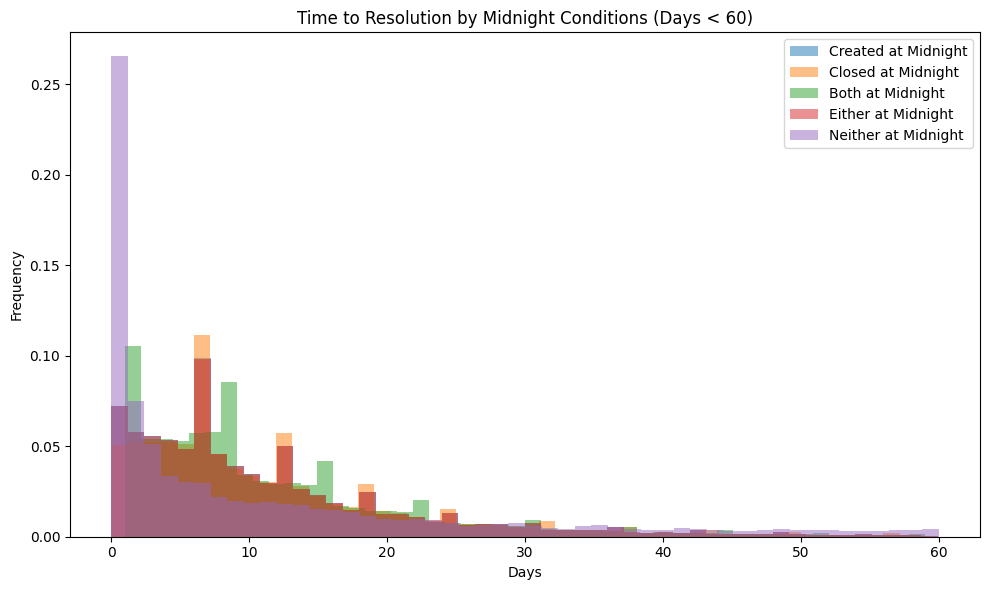

Created at Midnight - Count: 220298
Closed at Midnight - Count: 164478
Both at Midnight - Count: 163323
Either at Midnight - Count: 221453
Neither at Midnight - Count: 386287


In [26]:
# Create subsets based on midnight conditions
created_midnight = df_orig[df_orig['created_at_midnight'] == True]
closed_midnight = df_orig[df_orig['closed_at_midnight'] == True]
both_midnight = df_orig[(df_orig['created_at_midnight'] == True) & (df_orig['closed_at_midnight'] == True)]
neither_midnight = df_orig[(df_orig['created_at_midnight'] == False) & (df_orig['closed_at_midnight'] == False)]
either_midnight = df_orig[(df_orig['created_at_midnight'] == True) | (df_orig['closed_at_midnight'] == True)]

# Create single histogram with all four distributions
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert time_to_resolution to days for better visualization
created_midnight_days = created_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
closed_midnight_days = closed_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
both_midnight_days = both_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
neither_midnight_days = neither_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)
either_midnight_days = either_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)

upper = 60
created_midnight_days = created_midnight_days[created_midnight_days < upper]
closed_midnight_days = closed_midnight_days[closed_midnight_days < upper]
both_midnight_days = both_midnight_days[both_midnight_days < upper]
neither_midnight_days = neither_midnight_days[neither_midnight_days < upper]
either_midnight_days = either_midnight_days[either_midnight_days < upper]

# Plot all histograms on the same axes
ax.hist(created_midnight_days, bins=50, alpha=0.5, label='Created at Midnight', density= True)
ax.hist(closed_midnight_days, bins=50, alpha=0.5, label='Closed at Midnight', density= True)
ax.hist(both_midnight_days, bins=50, alpha=0.5, label='Both at Midnight', density= True)
ax.hist(either_midnight_days, bins=50, alpha=0.5, label='Either at Midnight', density= True)
ax.hist(neither_midnight_days, bins=50, alpha=0.5, label='Neither at Midnight', density= True)

ax.set_title('Time to Resolution by Midnight Conditions (Days < 60)')
ax.set_xlabel('Days')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Created at Midnight - Count:", len(created_midnight))
print("Closed at Midnight - Count:", len(closed_midnight))
print("Both at Midnight - Count:", len(both_midnight))
print("Either at Midnight - Count:", len(either_midnight))
print("Neither at Midnight - Count:", len(neither_midnight))


C:\Users\gorav\AppData\Local\Temp\ipykernel_30376\2387724668.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='time_to_resolution_days_rounded'>

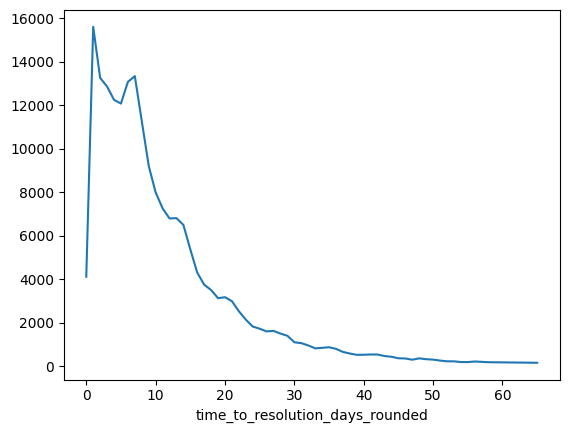

In [27]:
either_midnight = df_orig[(df_orig['created_at_midnight'] == True) | (df_orig['closed_at_midnight'] == True)]
either_midnight['time_to_resolution_days_rounded'] = (either_midnight['time_to_resolution'].dt.total_seconds() / (24 * 3600)).round(0)

either_midnight['time_to_resolution_days_rounded'].value_counts().iloc[:60].sort_index().plot()

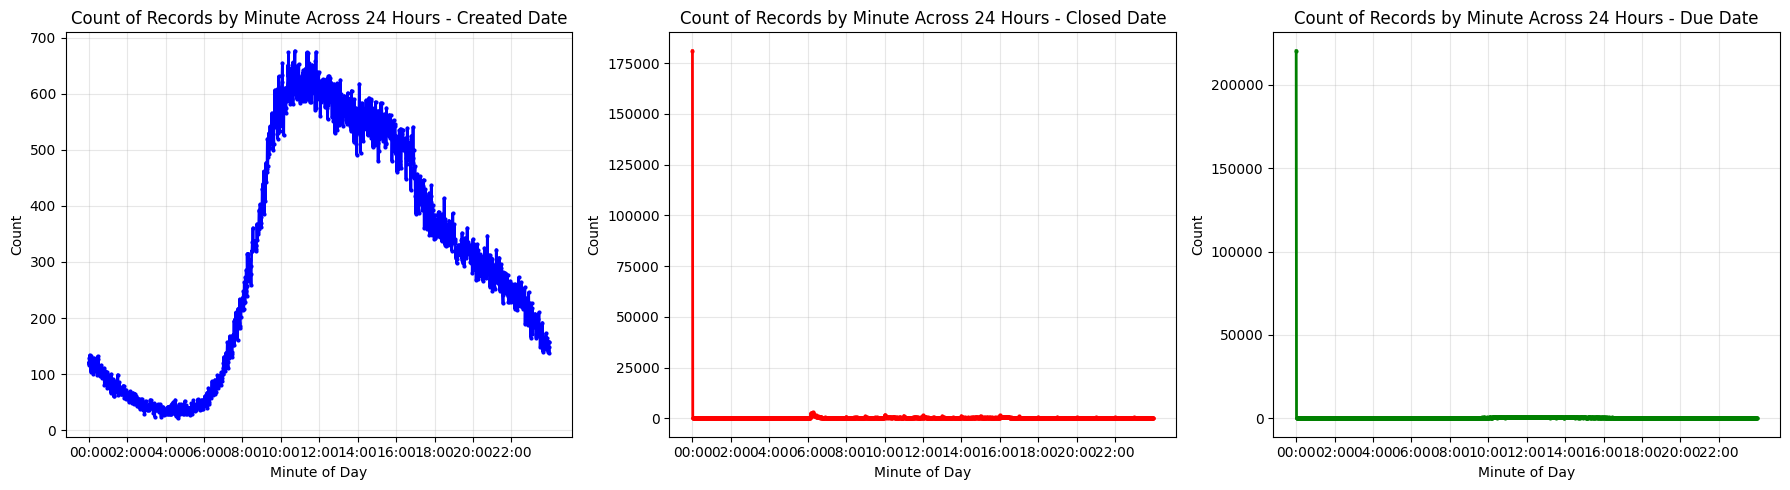

In [79]:
# Plot count of records by minute across 24 hours for created, closed, and due dates
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define the data and parameters for each subplot
date_columns = ['due_date' ,'closed_date', 'created_date', ]
colors = ['blue', 'red', 'green']
titles = ['Created Date', 'Closed Date', 'Due Date']

for i, (date_col, color, title) in enumerate(zip(date_columns, colors, titles)):
    # Handle missing data for closed and due dates
    if date_col == 'created_date':
        df_subset = df_orig
    else:
        df_subset = df_orig.dropna(subset=[date_col])
    
    # Calculate minute of day
    hours = df_subset[date_col].dt.hour
    minutes = df_subset[date_col].dt.minute
    minute_of_day = hours * 60 + minutes
    minute_counts = minute_of_day.value_counts().sort_index()
    
    # Plot
    axes[i].plot(minute_counts.index, minute_counts.values, marker='o', linewidth=2, markersize=2, color=color)
    axes[i].set_title(f'Count of Records by Minute Across 24 Hours - {title}')
    axes[i].set_xlabel('Minute of Day')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(range(0, 1440, 120))
    axes[i].set_xticklabels([f'{h:02d}:00' for h in range(0, 24, 2)])
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [92]:
df_subset = df_orig.copy()

df_subset['created_date_hour'] = df_subset['created_date'].dt.hour
df_subset['created_date_minute'] = df_subset['created_date'].dt.minute
df_subset['created_date_second'] = df_subset['created_date'].dt.second

df_subset[(df_subset['created_date_hour'] == 0) & (df_subset['created_date_minute'] == 0)]['created_date_second'].value_counts()

created_date_second
0     220301
13         8
45         6
56         6
21         5
48         5
3          5
6          5
41         4
40         4
37         4
34         4
25         4
36         3
16         3
29         3
46         3
11         3
24         3
49         3
28         3
33         3
19         3
8          3
52         3
31         3
35         3
30         3
58         3
7          2
59         2
53         2
26         2
9          2
15         2
38         2
57         2
10         2
50         2
43         2
18         2
12         2
5          2
32         2
14         2
17         2
23         2
1          2
2          1
39         1
55         1
27         1
51         1
44         1
42         1
22         1
4          1
Name: count, dtype: int64

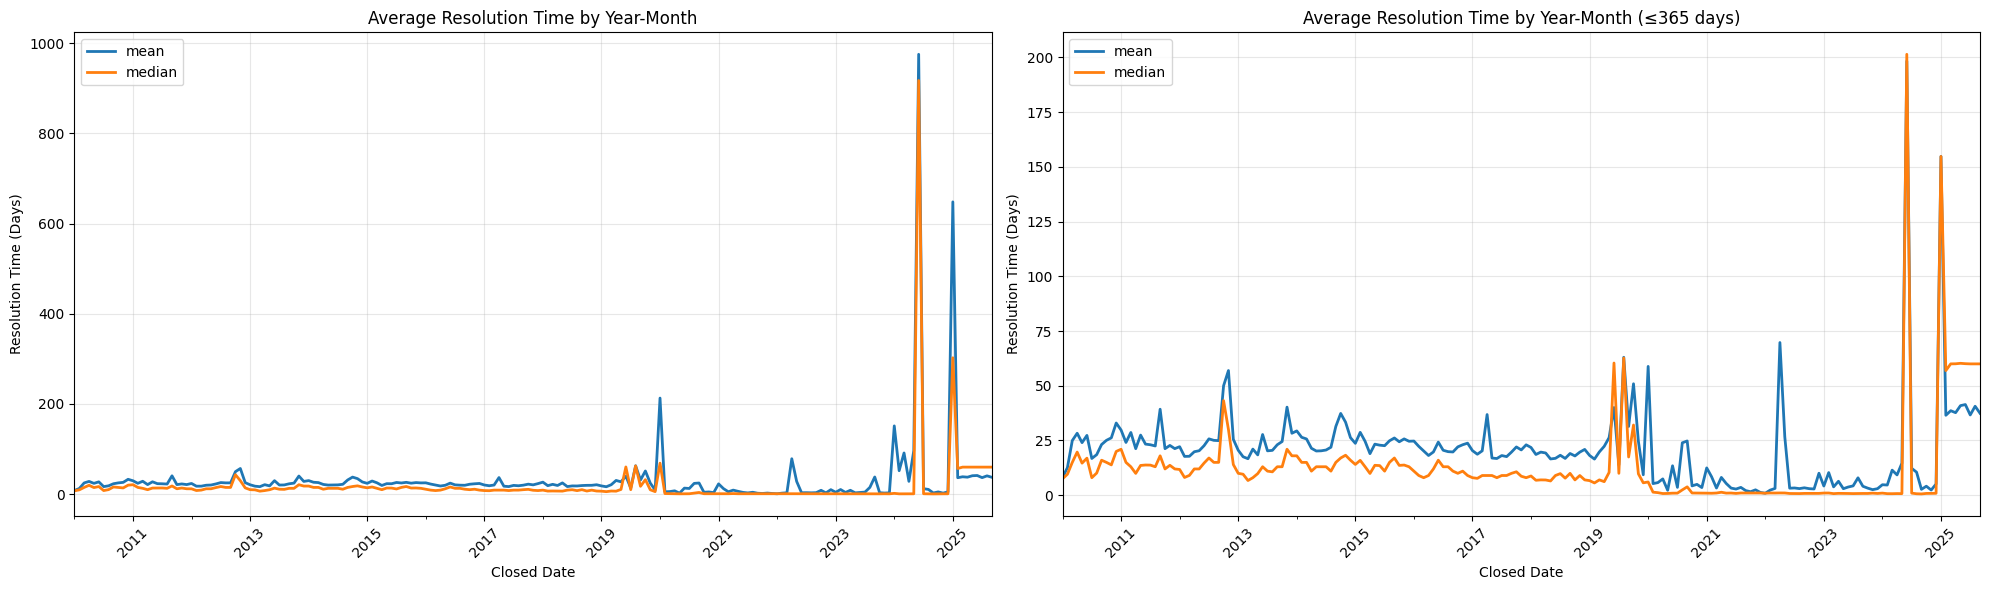

In [75]:
df_orig['year_month'] = df_orig['closed_date'].dt.to_period('M')
df_orig['time_to_resolution_days'] = df_orig['time_to_resolution'].dt.total_seconds() / (24 * 3600)
df_filtered = df_orig[df_orig['time_to_resolution'].dt.days <= 365]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Calculate median and mean resolution time by year-month for all data
year_month_stats_all = df_orig.groupby('year_month')['time_to_resolution_days'].agg(['mean', 'median']).sort_index()

# Plot resolution time by year-month (all data)
year_month_stats_all.plot(kind='line', linewidth=2, markersize=4, ax=axes[0])
axes[0].set_title('Average Resolution Time by Year-Month')
axes[0].set_xlabel('Closed Date')
axes[0].set_ylabel('Resolution Time (Days)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Calculate median and mean resolution time by year-month for filtered data
year_month_stats_filtered = df_filtered.groupby('year_month')['time_to_resolution_days'].agg(['mean', 'median']).sort_index()

# Plot resolution time by year-month (filtered data)
year_month_stats_filtered.plot(kind='line', linewidth=2, markersize=4, ax=axes[1])
axes[1].set_title('Average Resolution Time by Year-Month (≤365 days)')
axes[1].set_xlabel('Closed Date')
axes[1].set_ylabel('Resolution Time (Days)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
df_long_resolution = df_orig[df_orig['time_to_resolution'].dt.days > 365]
display(df_long_resolution['closed_date'].dt.date.value_counts(normalize=True))
df_long_resolution = df_long_resolution[(df_long_resolution['closed_date'].dt.date).isin([date(2024, 6, 3), date(2024, 6, 4)])]
df_long_resolution['resolution_description'].value_counts()


closed_date
2024-06-03    0.526994
2024-06-04    0.214259
2025-01-11    0.144517
2025-01-10    0.068923
2025-01-09    0.020261
                ...   
2021-01-08    0.000014
2023-04-11    0.000014
2023-07-06    0.000014
2024-03-19    0.000014
2025-01-13    0.000014
Name: proportion, Length: 150, dtype: float64

resolution_description
This SR was administratively closed. The issue you reported was addressed.    53451
Name: count, dtype: int64

In [98]:
df_orig.columns

Index(['due_date', 'landmark', 'intersection_street_1',
       'intersection_street_2', 'facility_type', 'cross_street_2',
       'cross_street_1', 'bbl', 'location_type', 'street_name',
       'incident_address', 'address_type', 'longitude', 'latitude',
       'x_coordinate_state_plane', 'y_coordinate_state_plane', 'city',
       'incident_zip', 'resolution_description', 'closed_date',
       'resolution_action_updated_date', 'descriptor', 'community_board',
       'park_borough', 'borough', 'unique_key', 'created_date', 'agency_name',
       'agency', 'complaint_type', 'status', 'open_data_channel_type',
       'park_facility_name', 'year', 'month', 'created_date_hour',
       'complaint_family', 'descriptor_clean', 'potential_inspection_trigger',
       'trigger_category', 'resolution_outcome', 'date', 'time_to_resolution',
       'time_closed_to_resolution_update', 'closed_before_created',
       'identical_created_closed_dates', 'created_at_midnight',
       'closed_at_midnight', 

In [99]:
df_orig[df_orig['resolution_description'] == 'This SR was administratively closed. The issue you reported was addressed.']['resolution_outcome']

438464    unknown
438486    unknown
438492    unknown
438495    unknown
438496    unknown
           ...   
809936    unknown
809942    unknown
809944    unknown
809945    unknown
850487    unknown
Name: resolution_outcome, Length: 65456, dtype: object

complaint_family
vector_control          252620
food_safety             198120
air_smoke_mold          120746
animal_control           36254
housing_health           16299
childcare_recreation     14255
hazmat_lead_asbestos     12863
tobacco_enforcement       8104
water_quality             2890
misc_other                2028
cooling_tower              199
Name: count, dtype: int64

In [103]:
df_orig['complaint_type'].value_counts()

complaint_type
Rodent                        216154
Food Establishment            134180
Indoor Air Quality             67676
Food Poisoning                 41436
Smoking                        28916
                               ...  
Illegal Animal - Sold/Kept         1
Injured Wildlife                   1
Traffic Signal Condition           1
ASBESTOS                           1
Lost Property                      1
Name: count, Length: 61, dtype: int64

In [102]:
df_orig[df_orig['resolution_outcome'] == 'unknown']['resolution_description'].value_counts()

resolution_description
This SR was administratively closed. The issue you reported was addressed.                                                                                                                                                                                      65456
The NYC Health Department has responded to your service request. For inspection results, please call (212) 676-1600 or email infobfscs@health.nyc.gov to request an inspection report. This service request has been closed.                                    27166
The NYC Health Department has responded to your service request.  Restaurant inspection information can be found online at www.nyc.gov/health/abceats. This service request has been closed.                                                                    14979
The NYC Health Department has investigated your complaint. You can get the status by calling 311 or (646) 632-6101 on weekdays between 9 AM and 5 PM. This service request has been closed.    

In [95]:
df_long_resolution.shape

(53451, 52)

In [24]:
df_long_resolution = df_valid_resolution[df_valid_resolution['time_to_resolution'].dt.days > 365]
df_long_resolution['resolution_description'].value_counts()


resolution_description
This SR was administratively closed. The issue you reported was addressed.                                                                                                                                                                                    53463
The NYC Health Department has responded to your service request. For inspection results, please call (212) 676-1600 or email infobfscs@health.nyc.gov to request an inspection report. This service request has been closed.                                  12132
The NYC Health Department has investigated your complaint. You can get the status by calling 311 or (646) 632-6101 on weekdays between 9 AM and 5 PM. This service request has been closed.                                                                    4511
Thank you for your report. The Department of Health and Mental Hygiene will use the information that you provided to help track and control mosquito populations throughout the City. No further info

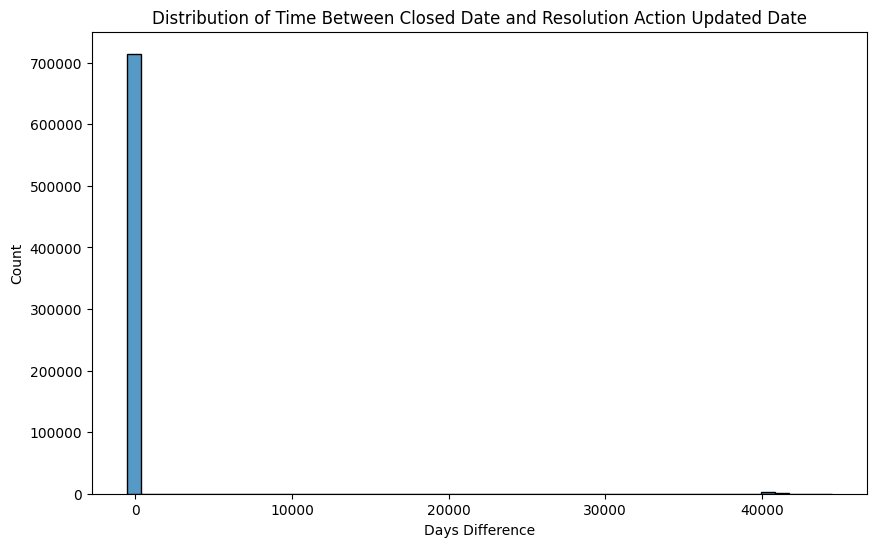

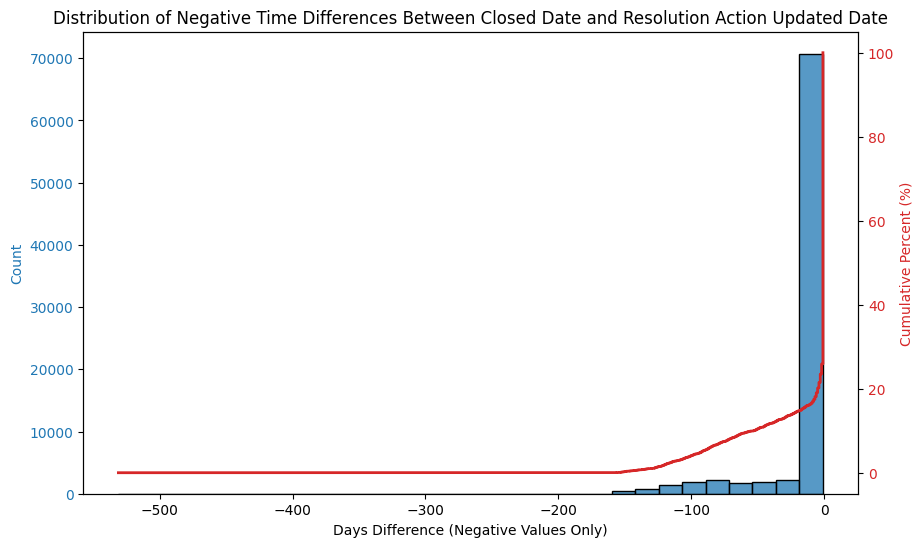

In [25]:
# Calculate time between closed_date and resolution_action_updated_date
# Remove rows where either date is NaT
df_with_update_times = df_temp.dropna(subset=['closed_date', 'resolution_action_updated_date'])

# Create histogram of time difference using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_with_update_times, x=df_with_update_times['time_closed_to_resolution_update'].dt.days, bins=50)
plt.title('Distribution of Time Between Closed Date and Resolution Action Updated Date')
plt.xlabel('Days Difference')
plt.ylabel('Count')
plt.show()

# Create plot with cumulative percent for negative time differences only
df_negative_times = df_with_update_times[df_with_update_times['time_closed_to_resolution_update'].dt.days < 0]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create histogram on primary y-axis
sns.histplot(data=df_negative_times, x=df_negative_times['time_closed_to_resolution_update'].dt.days, bins=30, ax=ax1)
ax1.set_xlabel('Days Difference (Negative Values Only)')
ax1.set_ylabel('Count', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis for cumulative percent
ax2 = ax1.twinx()
days_negative = df_negative_times['time_closed_to_resolution_update'].dt.days.sort_values()
cumulative_percent = [(i / len(days_negative)) * 100 for i in range(1, len(days_negative) + 1)]
ax2.plot(days_negative, cumulative_percent, color='tab:red', linewidth=2, label='Cumulative Percent')
ax2.set_ylabel('Cumulative Percent (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Negative Time Differences Between Closed Date and Resolution Action Updated Date')
plt.show()


In [26]:
# Analyze patterns by borough and complaint type
print("Identical created/closed dates by borough:")
print(df_temp.groupby('borough')['identical_created_closed_dates'].agg(['count', 'sum', 'mean']).round(3))

print("\nIdentical created/closed dates by complaint type:")
print(df_temp.groupby('complaint_type')['identical_created_closed_dates'].agg(['count', 'sum', 'mean']).round(3).sort_values('mean', ascending=False).head(10))

Identical created/closed dates by borough:
                count    sum   mean
borough                            
BRONX          135972  35975  0.265
BROOKLYN       261923  58012  0.221
MANHATTAN      228558  43521  0.190
QUEENS         176031  33646  0.191
STATEN ISLAND   46434   8771  0.189
Unspecified      1832      4  0.002

Identical created/closed dates by complaint type:
                                 count     sum   mean
complaint_type                                       
Pet Shop                          1094     930  0.850
Rodent                          372247  154910  0.416
Unsanitary Pigeon Condition      10091    4016  0.398
Pet Sale                           111      39  0.351
Illegal Animal Sold                931     277  0.298
Illegal Animal Kept as Pet        4985    1487  0.298
Unsanitary Animal Pvt Property   28211    8345  0.296
Unleashed Dog                    14139    3987  0.282
Animal Facility - No Permit       1098     219  0.199
Standing Water          

In [27]:
df_identical_dates = df_temp[df_temp['identical_created_closed_dates'] == 1]
df_identical_dates['resolution_action_updated_date'].isna().mean()

np.float64(0.0)

C:\Users\gorav\AppData\Local\Temp\ipykernel_13396\4034230520.py:40: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\contextily\tile.py:645: UserWarning:

The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).



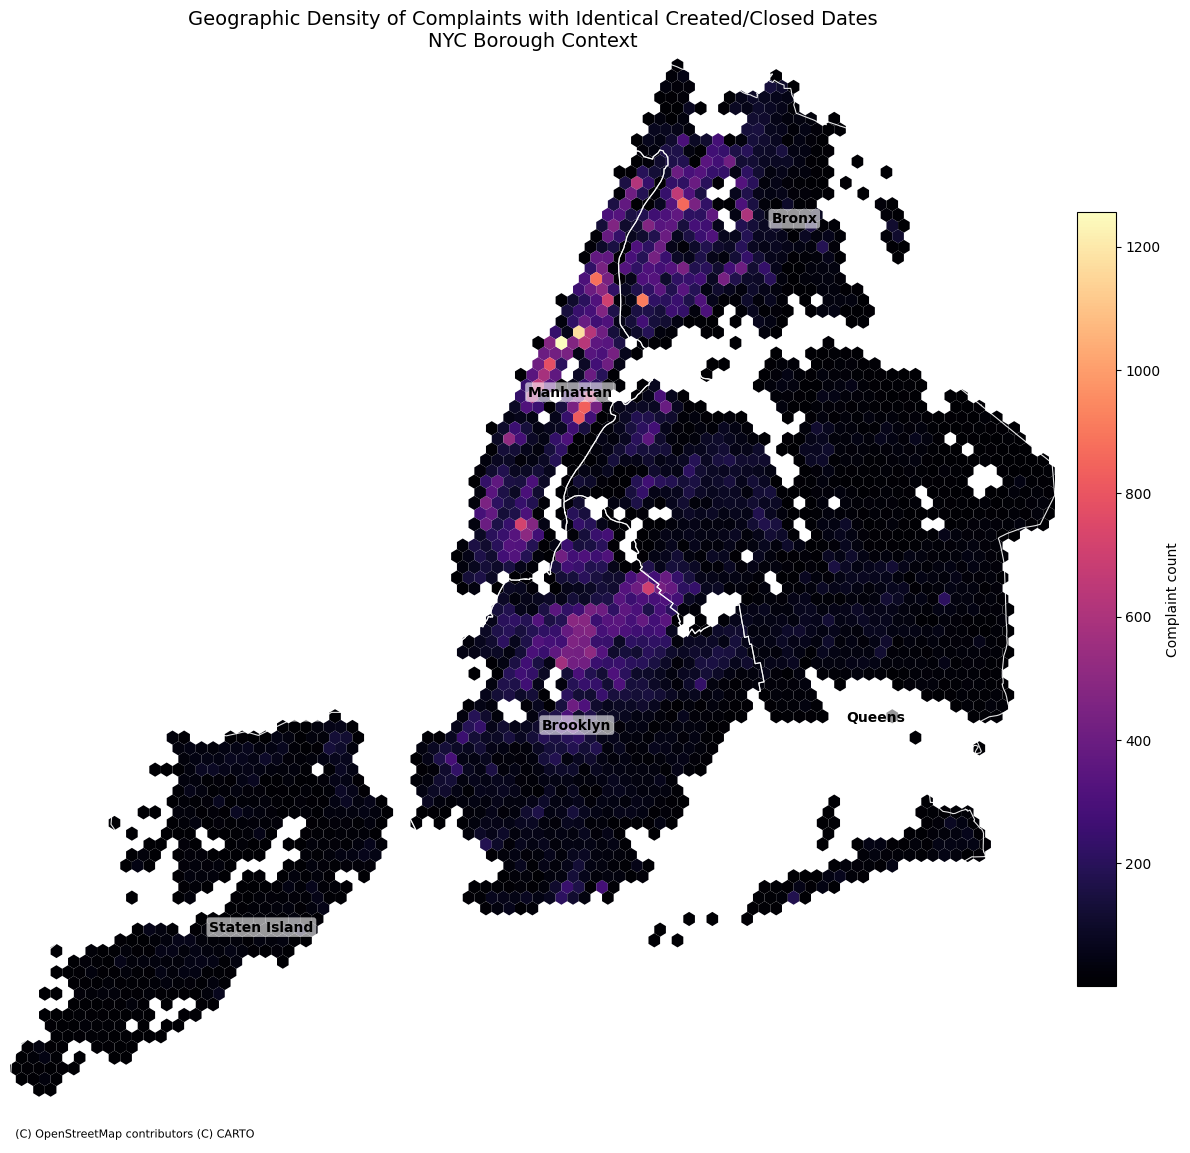

In [ ]:
# Example usage with the existing data
fig, ax = plott_function.create_hexbin_density_map(
    df_identical_dates, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Complaints with Identical Created/Closed Dates\nNYC Borough Context"
)
plt.show()


In [116]:
df_started_at_midnight = df_temp[df_temp['identical_created_closed_dates'] != 1]
df_started_at_midnight = df_started_at_midnight[df_started_at_midnight['created_at_midnight'] == 1]
df_started_at_midnight.groupby('closed_at_midnight')['time_to_resolution'].describe()

,count,mean,std,min,25%,50%,75%,max
closed_at_midnight,,,,,,,,
False,54738,11 days 12:58:42.290000,44 days 13:52:26.767000,-6208 days +02:03:19,1 days 16:11:07.250000,6 days 14:27:05,13 days 12:03:10.750000,1559 days 07:41:55
True,178037,13 days 00:44:04.843000,280 days 12:45:45.125000,-42872 days +00:00:00,5 days 00:00:00,9 days 00:00:00,17 days 00:00:00,1513 days 00:00:00


In [129]:
most_common_resolution_description = df_started_at_midnight[df_started_at_midnight['closed_at_midnight'] == 1]['resolution_description'].value_counts().index[0]
df_started_at_midnight[(df_started_at_midnight['closed_at_midnight'] == 1) & (df_started_at_midnight['resolution_description'] == most_common_resolution_description)]['complaint_type'].value_counts(normalize=True)

complaint_type
Rodent                            0.906120
Unsanitary Animal Pvt Property    0.071734
Unsanitary Pigeon Condition       0.022131
DPR Internal                      0.000007
DOF Literature Request            0.000007
Name: proportion, dtype: float64

In [125]:
df_started_at_midnight[df_started_at_midnight['closed_at_midnight'] == 1]['resolution_description'].value_counts(normalize=True)

resolution_description
The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              0.784902
The Department of Health and Menta

In [122]:
df_started_at_midnight[df_started_at_midnight['closed_at_midnight'] == 1]['descriptor'].value_counts(normalize=True).cumsum()

descriptor
Rat Sighting                    0.432331
Condition Attracting Rodents    0.665805
Mouse Sighting                  0.776406
Signs of Rodents                0.835360
Other - Explain Below           0.861501
Dog                             0.885035
Swimming Pool - Unmaintained    0.903969
Pigeon Waste                    0.920348
Puddle in Ground                0.934261
Animal Waste                    0.946197
Cat                             0.957335
Animal Odor                     0.964249
Container - Over 5 Gallons      0.970085
Other Animal                    0.974359
Puddle on Roof                  0.977954
Swimming Pool Cover             0.981313
Puddle on Sidewalk              0.984537
Sewer or Drain                  0.987598
Building Foundation             0.989671
Tires                           0.991580
Puddle on Driveway              0.993097
Pigeon Odor                     0.994501
Container - Under 5 Gallons     0.995782
Roof Gutters                    0.996973
Basem

In [95]:


print("\nCreated at midnight by borough:")
print(df_temp.groupby('borough')['created_at_midnight'].agg(['count', 'sum', 'mean']).round(3))

print("\nCreated at midnight by complaint type:")
print(df_temp.groupby('complaint_type')['created_at_midnight'].agg(['count', 'sum', 'mean']).round(3).sort_values('mean', ascending=False).head(10))



Created at midnight by borough:
                count    sum   mean
borough                            
BRONX          162633  55883  0.344
BROOKLYN       322348  93057  0.289
MANHATTAN      282206  67310  0.239
QUEENS         207314  55223  0.266
STATEN ISLAND   53459  18520  0.346
Unspecified      2059    110  0.053

Created at midnight by complaint type:
                                 count     sum   mean
complaint_type                                       
DOF Literature Request               1       1  1.000
DPR Internal                         1       1  1.000
Traffic Signal Condition             1       1  1.000
Standing Water                   30015   16944  0.565
MOLD                                 2       1  0.500
Rodent                          488764  233120  0.477
Food Poisoning                   45307   20734  0.458
Unsanitary Animal Pvt Property   34422   15097  0.439
Unsanitary Pigeon Condition      12867    4202  0.327
Unlicensed Dog                      81       

In [96]:

print("\nClosed at midnight by borough:")
print(df_temp.groupby('borough')['closed_at_midnight'].agg(['count', 'sum', 'mean']).round(3))

print("\nClosed at midnight by complaint type:")
print(df_temp.groupby('complaint_type')['closed_at_midnight'].agg(['count', 'sum', 'mean']).round(3).sort_values('mean', ascending=False).head(10))


Closed at midnight by borough:
                count    sum   mean
borough                            
BRONX          162633  44575  0.274
BROOKLYN       322348  73450  0.228
MANHATTAN      282206  53740  0.190
QUEENS         207314  45122  0.218
STATEN ISLAND   53459  15830  0.296
Unspecified      2059      2  0.001

Closed at midnight by complaint type:
                                 count     sum   mean
complaint_type                                       
DOF Literature Request               1       1  1.000
DPR Internal                         1       1  1.000
Standing Water                   30015   16060  0.535
Rodent                          488764  196272  0.402
Unsanitary Animal Pvt Property   34422   11779  0.342
Unsanitary Pigeon Condition      12867    3440  0.267
Non-Residential Heat             16864    1925  0.114
Smoking                          35456    3007  0.085
Calorie Labeling                   203       7  0.034
Unlicensed Dog                      81       1 

In [ ]:
df_dohmh[df_dohmh['status'] == 'Closed'].iloc[2]['resolution_description']

In [ ]:
def map_complaints(df):
        complaint_to_family = {
        "Food Establishment": "food_safety",
        "Rodent": "vector_control",
        "Non-Residential Heat": "housing_health",
        "Food Poisoning": "food_safety",
        "Unsanitary Animal Pvt Property": "animal_control",
        "Smoking": "air_smoke_mold",
        "Indoor Air Quality": "air_smoke_mold",
        "Window Guard": "housing_health",
        "Unsanitary Pigeon Condition": "vector_control",
        "Harboring Bees/Wasps": "vector_control",
        "Asbestos": "hazmat_lead_asbestos",
        "Unleashed Dog": "animal_control",
        "Unsanitary Animal Facility": "animal_control",
        "Tattooing": "childcare_recreation",
        "Beach/Pool/Sauna Complaint": "childcare_recreation",
        "Animal Facility - No Permit": "animal_control",
        "Mold": "air_smoke_mold",
        "Portable Toilet": "misc_other",
        "Illegal Animal Kept as Pet": "animal_control",
        "Calorie Labeling": "food_safety",
        "Drinking Water": "water_quality",
        "Poison Ivy": "misc_other",
        "Illegal Animal Sold": "animal_control",
        "Bottled Water": "water_quality",
        "Radioactive Material": "hazmat_lead_asbestos",
        "Lifeguard": "childcare_recreation",
        "Trans Fat": "food_safety",
        "Summer Camp": "childcare_recreation",
        "X-Ray Machine/Equipment": "hazmat_lead_asbestos",
        "Trapping Pigeon": "vector_control",
        "Indoor Sewage": "air_smoke_mold",
        "Damaged Tree": "misc_other",
        "Unlicensed Dog": "animal_control",
        "Standing Water": "vector_control",
        "DPR Internal": "misc_other",
        "DOF Literature Request": "misc_other",
        "Animal in a Park": "animal_control",
        "Tanning": "childcare_recreation",
        "Day Care": "childcare_recreation",
        "Asbestos/Garbage Nuisance": "hazmat_lead_asbestos",
        "Mosquitoes": "vector_control",
        "LEAD": "hazmat_lead_asbestos",
        "Forms": "misc_other",
        "MOLD": "air_smoke_mold",
        "Cooling Tower": "cooling_tower",
        "Pet Shop": "animal_control",
        "Traffic Signal Condition": "misc_other",
        "Injured Wildlife": "animal_control",
        "Illegal Animal - Sold/Kept": "animal_control",
        "Mobile Food Vendor": "food_safety",
        "Construction Lead Dust": "hazmat_lead_asbestos",
        "Peeling Paint": "hazmat_lead_asbestos",
        "Vaccine Mandate Non-Compliance": "tobacco_enforcement",
        "Face Covering Violation": "tobacco_enforcement",
        "Private School Vaccine Mandate Non-Compliance": "tobacco_enforcement",
        "Building Drinking Water Tank": "water_quality",
        "Smoking or Vaping": "air_smoke_mold",
        "Tobacco or Non-Tobacco Sale": "tobacco_enforcement",
        "ASBESTOS": "hazmat_lead_asbestos",
        "Pet Sale": "animal_control",
        "Lost Property": "misc_other",
        }

        # Optional family -> skill tag used in staffing
        family_to_skill = {
        "food_safety": "food",
        "vector_control": "vector",
        "air_smoke_mold": "ieq",
        "hazmat_lead_asbestos": "hazmat",
        "water_quality": "water",
        "cooling_tower": "legionella",
        "animal_control": "animal",
        "childcare_recreation": "community_env",
        "tobacco_enforcement": "enforcement",
        "housing_health": "community_env",
        "misc_other": "generalist",
        }

        # Apply to your dataframe `df`
        df = df.copy()
        df["family"] = df["complaint_type"].map(complaint_to_family)
        df["skill_tag"] = df["family"].map(family_to_skill)

        return df

In [137]:
df_orig['descriptor'].unique().tolist()

['Bare Hands in Contact w/ Food',
 'Rat Sighting',
 'Inadequate or No Heat',
 '1 or 2',
 'Animal Waste',
 'Condition Attracting Rodents',
 'Mouse Sighting',
 'Kitchen/Food Prep Area',
 'Smoking Violation',
 'Chemical Vapors/Gases/Odors',
 'Food Spoiled',
 'Other (Explain Below)',
 'Inside Apartment',
 'Food Worker Hygiene',
 'Food Worker Activity',
 'Pigeon Waste',
 'Pigeon Odor',
 'Bees/Wasps - Private Property',
 'Animal Odor',
 'N/A',
 '3 or More',
 'Ventilation',
 'Rodents/Insects/Garbage',
 'Sewage',
 'Food Contaminated',
 'Permit/License/Certificate',
 'Food Temperature',
 'Unleashed Dog in Public',
 'Public Area',
 'Signs of Rodents',
 'Dishwashing/Utensils',
 'Toxic Chemical/Material',
 'Food Contains Foreign Object',
 'Tattoo Artist Unlicensed',
 'Food Protection',
 'Pet/Animal',
 'Odor',
 'Toilet Facility',
 'Water',
 'Food Preparation Location',
 'Facility Maintenance',
 'Plumbing',
 'Workplace - 10 or Less Staff',
 'Unsanitary Condition',
 'Public Complaint - Comm Location'

# TODO:
1. Create a mapping for the output from resolution_description
2. Create a mapping for the output from descriptor
3. Drop excesivly long ticket when it comes to duration
4. drop where closed > created
4. Drop data were created and closed date is the same because we can't tell when the service request was opened, we can't tell the duration or anything else
5.

### Population Data

In [31]:
df_pop = pd.read_csv(config.CENSUS_DATA_PATH)
df_pop['GEOID'] = df_pop['GEOID'].astype(str)

In [32]:
df_2023 = df_pop[df_pop['year'] == 2023][['GEOID', 'population']].rename(
    columns={"population": "pop_2023"}
)
df_2018 = df_pop[df_pop['year'] == 2018][['GEOID', 'population']].rename(
    columns={"population": "pop_2018"}
)

# Merge to calculate percent change (forward)
df_change_forward = df_2018.merge(df_2023, on='GEOID', how='inner')
df_change_forward['pct_change_5yr'] = (
    (df_change_forward['pop_2023'] - df_change_forward['pop_2018']) / df_change_forward['pop_2018']
)
df_change_forward['annual_change'] = df_change_forward['pct_change_5yr'] / 5

# Calculate overall population change rate for fallback (forward)
overall_pop_2018 = df_change_forward['pop_2018'].sum()
overall_pop_2023 = df_change_forward['pop_2023'].sum()
overall_pct_change_5yr_forward = (overall_pop_2023 - overall_pop_2018) / overall_pop_2018
overall_annual_change_forward = overall_pct_change_5yr_forward / 5

# For values where annual_change is inf or nan, use the overall population change rate
df_change_forward['annual_change'] = df_change_forward['annual_change'].fillna(overall_annual_change_forward)
df_change_forward['annual_change'] = df_change_forward['annual_change'].replace(
    [float('inf'), float('-inf')], overall_annual_change_forward
)

# Calculate 2024 and 2025 populations
df_change_forward['pop_2024'] = df_change_forward['pop_2023'] * (1 + df_change_forward['annual_change'] * 1)
df_change_forward['pop_2025'] = df_change_forward['pop_2023'] * (1 + df_change_forward['annual_change'] * 2)

# Round to integers
df_change_forward['pop_2024'] = df_change_forward['pop_2024'].round()
df_change_forward['pop_2025'] = df_change_forward['pop_2025'].round()

# Create new rows for 2024 and 2025
df_2024 = df_change_forward[['GEOID', 'pop_2024']].rename(columns={'pop_2024': 'population'})
df_2024['year'] = 2024

df_2025 = df_change_forward[['GEOID', 'pop_2025']].rename(columns={'pop_2025': 'population'})
df_2025['year'] = 2025

# ========== BACKFILL: 2010, 2011, and 2012 ==========
# Get population data for 2013 and 2018 for each GEOID
df_2013 = df_pop[df_pop['year'] == 2013][['GEOID', 'population']].rename(
    columns={"population": "pop_2013"}
)
# Reuse df_2018 from above

# Merge to calculate percent change (backward)
df_change_backward = df_2013.merge(df_2018, on='GEOID', how='inner')
df_change_backward['pct_change_5yr'] = (
    (df_change_backward['pop_2018'] - df_change_backward['pop_2013']) / df_change_backward['pop_2013']
)
df_change_backward['annual_change'] = df_change_backward['pct_change_5yr'] / 5

# Calculate overall population change rate for fallback (backward)
overall_pop_2013 = df_change_backward['pop_2013'].sum()
overall_pop_2018_back = df_change_backward['pop_2018'].sum()
overall_pct_change_5yr_backward = (overall_pop_2018_back - overall_pop_2013) / overall_pop_2013
overall_annual_change_backward = overall_pct_change_5yr_backward / 5

# For values where annual_change is inf or nan, use the overall population change rate
df_change_backward['annual_change'] = df_change_backward['annual_change'].fillna(overall_annual_change_backward)
df_change_backward['annual_change'] = df_change_backward['annual_change'].replace(
    [float('inf'), float('-inf')], overall_annual_change_backward
)

# Calculate 2010, 2011, and 2012 populations (working backwards from 2013)
df_change_backward['pop_2012'] = df_change_backward['pop_2013'] * (1 + df_change_backward['annual_change'] * (-1))
df_change_backward['pop_2011'] = df_change_backward['pop_2013'] * (1 + df_change_backward['annual_change'] * (-2))
df_change_backward['pop_2010'] = df_change_backward['pop_2013'] * (1 + df_change_backward['annual_change'] * (-3))

# Round to integers
df_change_backward['pop_2012'] = df_change_backward['pop_2012'].round()
df_change_backward['pop_2011'] = df_change_backward['pop_2011'].round()
df_change_backward['pop_2010'] = df_change_backward['pop_2010'].round()

# Create new rows for 2010, 2011, and 2012
df_2012 = df_change_backward[['GEOID', 'pop_2012']].rename(columns={'pop_2012': 'population'})
df_2012['year'] = 2012

df_2011 = df_change_backward[['GEOID', 'pop_2011']].rename(columns={'pop_2011': 'population'})
df_2011['year'] = 2011

df_2010 = df_change_backward[['GEOID', 'pop_2010']].rename(columns={'pop_2010': 'population'})
df_2010['year'] = 2010

# Concatenate with original data
df_extended = pd.concat([df_pop, df_2010, df_2011, df_2012, df_2024, df_2025], ignore_index=True)

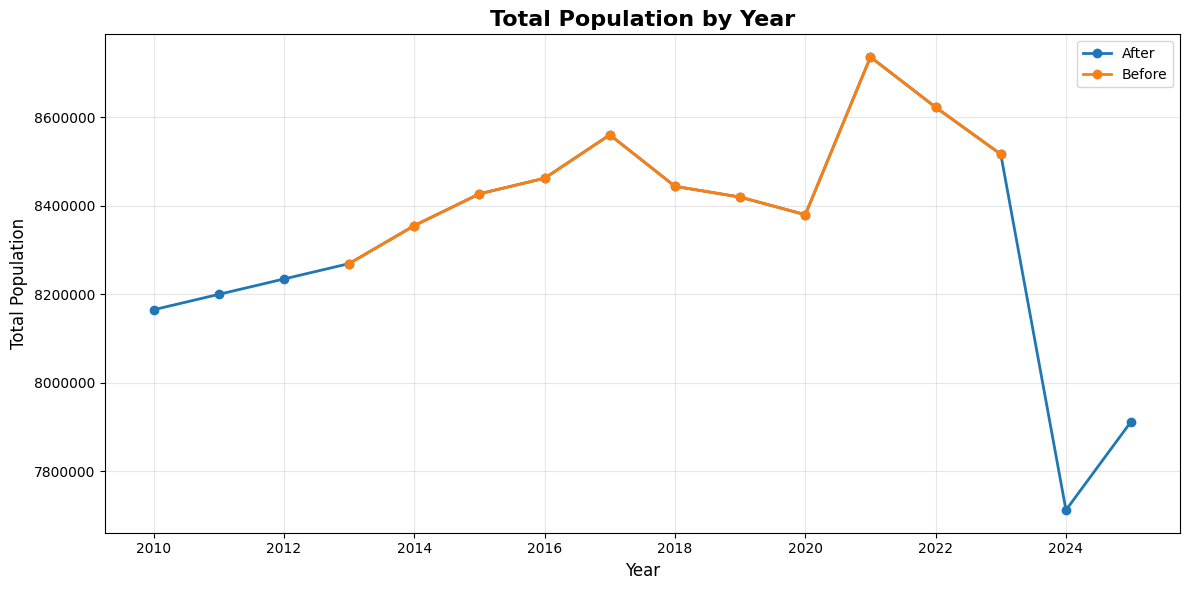

In [34]:
plt.figure(figsize=(12, 6))


yearly_pop = df_extended.groupby('year')['population'].sum()
plt.plot(yearly_pop.index, yearly_pop.values, marker='o', linewidth=2, markersize=6, label = 'After')
yearly_pop = df_pop.groupby('year')['population'].sum()
plt.plot(yearly_pop.index, yearly_pop.values, marker='o', linewidth=2, markersize=6, label = 'Before')
plt.title('Total Population by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Population', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.tight_layout()
plt.show()


### Weather Data

In [29]:
df_weather = pd.read_csv(config.WEATHER_DATA_PATH)
df_weather['fips'] = df_weather['fips'].astype(str)
df_weather['date'] = pd.to_datetime(df_weather['date'])

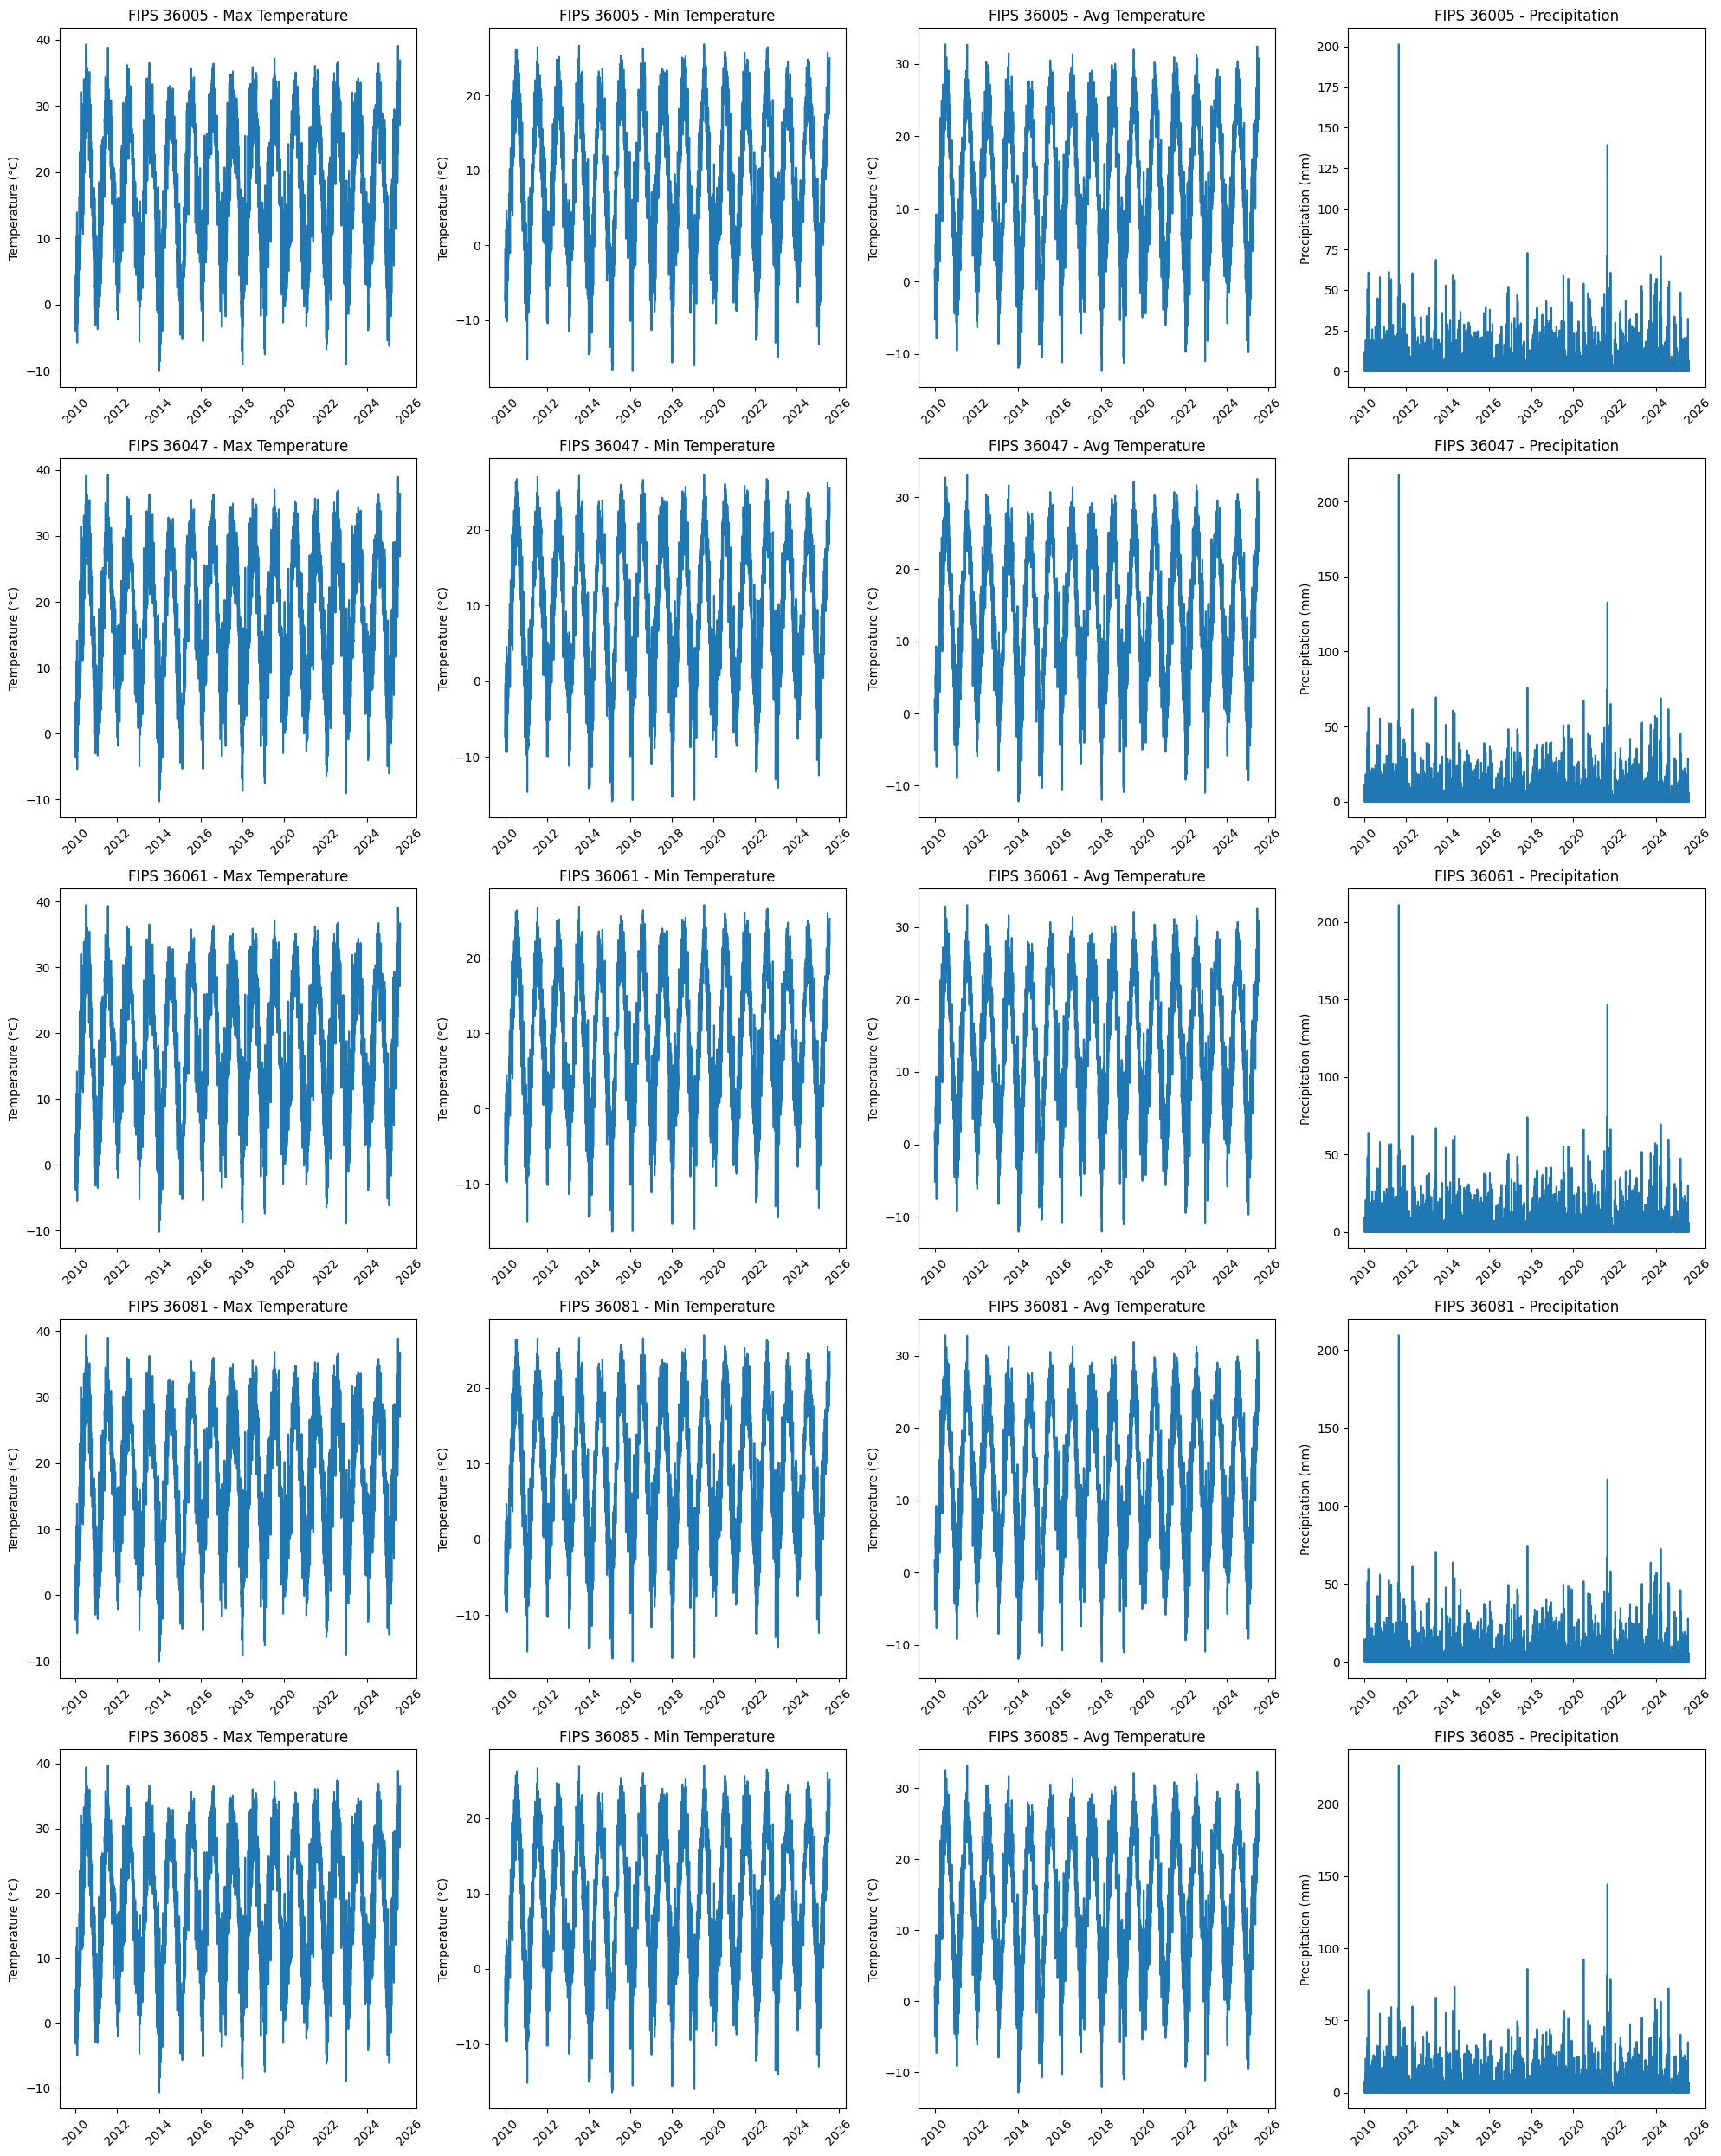

In [30]:
df_weather['tmax'] = df_weather['tmax'].astype(float)
df_weather['tmin'] = df_weather['tmin'].astype(float)
df_weather['tavg'] = df_weather['tavg'].astype(float)
df_weather['prcp'] = df_weather['prcp'].astype(float)

unique_fips = df_weather['fips'].unique()

fig, axes = plt.subplots(len(unique_fips), 4, figsize=(20, 5*len(unique_fips)))

for i, fips in enumerate(unique_fips):
    fips_data = df_weather[df_weather['fips'] == fips].sort_values('date')
    
    axes[i, 0].plot(fips_data['date'], fips_data['tmax'])
    axes[i, 0].set_title(f'FIPS {fips} - Max Temperature')
    axes[i, 0].set_ylabel('Temperature (°C)')
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    axes[i, 1].plot(fips_data['date'], fips_data['tmin'])
    axes[i, 1].set_title(f'FIPS {fips} - Min Temperature')
    axes[i, 1].set_ylabel('Temperature (°C)')
    axes[i, 1].tick_params(axis='x', rotation=45)
    
    axes[i, 2].plot(fips_data['date'], fips_data['tavg'])
    axes[i, 2].set_title(f'FIPS {fips} - Avg Temperature')
    axes[i, 2].set_ylabel('Temperature (°C)')
    axes[i, 2].tick_params(axis='x', rotation=45)

    axes[i, 3].plot(fips_data['date'], fips_data['prcp'])
    axes[i, 3].set_title(f'FIPS {fips} - Precipitation')
    axes[i, 3].set_ylabel('Precipitation (mm)')
    axes[i, 3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
